* 该脚本对Plating Seeds数据集进行初步探索，并寻找一个baseline模型。  
参考：  
https://zhuanlan.zhihu.com/p/41140947  
https://medium.com/neuralspace/kaggle-1-winning-approach-for-image-classification-challenge-9c1188157a86


In [51]:
import sys
from imutils import paths
import numpy as np
sys.path.append("..")
from pyimage.utils import SimpleDatasetLoader, plot_history, rank5_accuracy
from pyimage.preprocess import *
from pyimage.callbacks import TrainingMonitor
from keras.applications import resnet50, inception_resnet_v2
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model, Input
import matplotlib.pyplot as plt
import pdb

### Configrations

In [2]:
TRAINROOT = "../Dataset/Seeds/train/"
SAVEWEIGHTS='outputs/models/baseline_res50_noaug'
OUTPUTPATH = 'outputs/logs/'
BATCHSIZE=32
LR=0.1
SIZEINPUT=224
INPUTSHAPE=(224,224,3)

### K-folds Data Split  
* 参考：https://www.kaggle.com/stefanie04736/simple-keras-model-with-k-fold-cross-validation

In [25]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD
from os.path import join
import os
from datetime import datetime


In [6]:
def load_data_fold(k, trainRoot):
    igp = IgnoringAspectResizer(SIZEINPUT, SIZEINPUT)
    ip = ImageToArrayPreprocessor()
    sdl = SimpleDatasetLoader([igp, ip])
    imgPaths = list(paths.list_images(trainRoot))
    X, y = sdl.load(imgPaths, verbose=300)
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X, y))
    return folds, X, y

folds, X, y = load_data_fold(7, TRAINROOT)

[INFO] processed 300/4750
[INFO] processed 600/4750
[INFO] processed 900/4750
[INFO] processed 1200/4750
[INFO] processed 1500/4750
[INFO] processed 1800/4750
[INFO] processed 2100/4750
[INFO] processed 2400/4750
[INFO] processed 2700/4750
[INFO] processed 3000/4750
[INFO] processed 3300/4750
[INFO] processed 3600/4750
[INFO] processed 3900/4750
[INFO] processed 4200/4750
[INFO] processed 4500/4750


##### Data Augmentation

In [7]:
## 暂时不使用Aug

##### Model: Resnet50. Only the last FC is trainable

In [9]:
def get_model():
    baseModel = resnet50.ResNet50(include_top=False, classes=12, input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))
    features = baseModel.output
    x = Flatten()(features)
    x = Dense(12, activation='softmax')(x)
    model = Model(inputs=baseModel.inputs, outputs=x)

    for layer in model.layers[:-1]:
        layer.trainable=False
    sgd = SGD(lr=LR, momentum=0.9)
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
model = get_model()

In [11]:
# 注意：最后直接从2048 -> 12。 可以考虑再加个512 Dense?
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

##### Callbacks

In [10]:
def get_callbacks(outPath, name_weights, patience_lr, k):
    #time = datetime.now().strftime("%H-%M-%S")
    ##figPath = join(outPath, '{}_{}_{}.jpg'.format(os.getpid(), k, time))
    #jsonPath = join(outPath, '{}_{}_{}.json'.format(os.getpid(), k, time))
    #monitor = TrainingMonitor(figPath, jsonPath)
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

##### Train for K folds

In [11]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
classNames = lb.classes_
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = SAVEWEIGHTS+"_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(OUTPUTPATH, name_weights, patience_lr=10, k=j)
    #generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit( X_train_cv, y_train_cv, batch_size=BATCHSIZE,
               epochs=10,
               shuffle=True,
               verbose=1,
               validation_data = (X_valid_cv, y_valid_cv),
               callbacks = callbacks
             )
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Train on 4068 samples, validate on 682 samples
Epoch 1/10
4068/4068 [==============================] - 15s 4ms/step - loss: 6.4163 - acc: 0.4939 - val_loss: 9.8337 - val_acc: 0.3255
Epoch 2/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.2850 - acc: 0.6224 - val_loss: 9.2758 - val_acc: 0.3563
Epoch 3/10
4068/4068 [==============================] - 13s 3ms/step - loss: 4.9410 - acc: 0.6573 - val_loss: 9.6936 - val_acc: 0.3343
Epoch 4/10
4068/4068 [==============================] - 13s 3ms/step - loss: 4.7152 - acc: 0.6723 - val_loss: 9.3724 - val_acc: 0.3695
Epoch 5/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.4450 - acc: 0.6251 - val_loss: 10.2356 - val_acc: 0.3123
Epoch 6/10
4068/4068 [==============================] - 13s 3ms/step - loss: 4.7778 - acc: 0.6760 - val_loss: 10.6316 - val_acc: 0.2771
Epoch 7/10
4068/4068 [==============================] - 13s 3ms/step - loss: 4.5398 - acc: 0.6952 - val_loss: 12.1773 - val_acc: 0.2

#### 上一次实验结果太差，无法作为baseline。下面进行第二次baseline实验

In [12]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
classNames = lb.classes_
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = SAVEWEIGHTS+"_fold" + str(j) + "_weights.h5"
    #callbacks = get_callbacks(OUTPUTPATH, name_weights, patience_lr=10, k=j)
    callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]
    #generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit( X_train_cv, y_train_cv, batch_size=BATCHSIZE,
               epochs=10,
               shuffle=True,
               verbose=1,
               validation_data = (X_valid_cv, y_valid_cv),
               callbacks = callbacks
             )
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Train on 4068 samples, validate on 682 samples
Epoch 1/10
4068/4068 [==============================] - 19s 5ms/step - loss: 6.5586 - acc: 0.4762 - val_loss: 9.2390 - val_acc: 0.3240
Epoch 2/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.6236 - acc: 0.6045 - val_loss: 10.4239 - val_acc: 0.2625
Epoch 3/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.7904 - acc: 0.6028 - val_loss: 9.4784 - val_acc: 0.3358
Epoch 4/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.3039 - acc: 0.6396 - val_loss: 8.9618 - val_acc: 0.3710
Epoch 5/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.2454 - acc: 0.6477 - val_loss: 10.6466 - val_acc: 0.2478
Epoch 6/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.2135 - acc: 0.6549 - val_loss: 9.7457 - val_acc: 0.3079
Epoch 7/10
4068/4068 [==============================] - 13s 3ms/step - loss: 5.0667 - acc: 0.6640 - val_loss: 7.8799 - val_acc: 0.41

#### 第三次baseline实验：换成inception-resnet2

In [81]:
TRAINROOT = "../Dataset/Seeds/train/"
SAVEWEIGHTS='outputs/models/baseline_incepRes_noaug'
OUTPUTPATH = 'outputs/logs/'
BATCHSIZE=64
LR=0.001
SIZEINPUT=299
INPUTSHAPE=(299,299,3)

In [4]:
def get_model():
    baseModel = inception_resnet_v2.InceptionResNetV2(include_top=False, classes=12, 
                input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))
    features = baseModel.output
    x = Flatten()(features)
    x = Dense(12, activation='softmax')(x)
    model = Model(inputs=baseModel.inputs, outputs=x)

    for layer in model.layers[:-1]:
        layer.trainable=False
    sgd = SGD(lr=LR, momentum=0.9)
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [46]:
def load_data_fold(k, trainRoot):
    igp = IgnoringAspectResizer(SIZEINPUT, SIZEINPUT)
    ip = ImageToArrayPreprocessor()
    sdl = SimpleDatasetLoader([igp, ip])
    imgPaths = list(paths.list_images(trainRoot))
    X, y = sdl.load(imgPaths, verbose=300)
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X, y))
    return folds, X, y

folds, X, y = load_data_fold(7, TRAINROOT)

[INFO] processed 300/4750
[INFO] processed 600/4750
[INFO] processed 900/4750
[INFO] processed 1200/4750
[INFO] processed 1500/4750
[INFO] processed 1800/4750
[INFO] processed 2100/4750
[INFO] processed 2400/4750
[INFO] processed 2700/4750
[INFO] processed 3000/4750
[INFO] processed 3300/4750
[INFO] processed 3600/4750
[INFO] processed 3900/4750
[INFO] processed 4200/4750
[INFO] processed 4500/4750


###### 下面的实验犯了个很大的问题：
* 当使用InceptionResnet，设置include_top=False加载pretrain模型时，默认是只加载到GlobalAveragePooling上面一层。但是使用Resnet50则加载到了Flatten上面一层.  
* 故加载过pretrain之后，最好先summary看一下。因为可能需要添加层

In [6]:
# lb = LabelBinarizer()
# y = lb.fit_transform(y)
# classNames = lb.classes_
# for j, (train_idx, val_idx) in enumerate(folds):
    
#     print('\nFold ',j)
#     X_train_cv = X[train_idx]
#     y_train_cv = y[train_idx]
#     X_valid_cv = X[val_idx]
#     y_valid_cv= y[val_idx]
    
#     name_weights = SAVEWEIGHTS+"_fold" + str(j) + "_weights.h5"
#     #callbacks = get_callbacks(OUTPUTPATH, name_weights, patience_lr=10, k=j)
#     callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]
#     #generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
#     model = get_model()
#     model.fit( X_train_cv, y_train_cv, batch_size=BATCHSIZE,
#                epochs=10,
#                shuffle=True,
#                verbose=1,
#                validation_data = (X_valid_cv, y_valid_cv),
#                callbacks = callbacks
#              )
    
#     print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Train on 4068 samples, validate on 682 samples
Epoch 1/10
4068/4068 [==============================] - 38s 9ms/step - loss: 12.9621 - acc: 0.1812 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 2/10
4068/4068 [==============================] - 29s 7ms/step - loss: 13.0512 - acc: 0.1898 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 3/10
4068/4068 [==============================] - 29s 7ms/step - loss: 12.8001 - acc: 0.2055 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 4/10
4068/4068 [==============================] - 29s 7ms/step - loss: 12.8097 - acc: 0.2043 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 5/10
4068/4068 [==============================] - 29s 7ms/step - loss: 12.4890 - acc: 0.2232 - val_loss: 14.2510 - val_acc: 0.1158
Epoch 6/10
4068/4068 [==============================] - 29s 7ms/step - loss: 11.6091 - acc: 0.2765 - val_loss: 13.8729 - val_acc: 0.1393
Epoch 7/10
4068/4068 [==============================] - 30s 7ms/step - loss: 11.2338 - acc: 0.2999 - val_loss: 13.8965 - v

KeyboardInterrupt: 

#### 纠正模型并重新实验

In [3]:
def get_model_v2():
    baseModel = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',
                input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))
    features = baseModel.output
    x = GlobalAveragePooling2D(name="avg_pool")(features)
    #x = Flatten()(x) #注意：使用GlobalAveragePooling2D时，输出即为2D Tensor，无需再用Flatten
    x = Dense(12, activation='softmax')(x)
    model = Model(inputs=baseModel.inputs, outputs=x)

    for layer in model.layers[:-1]:
        layer.trainable=False
    sgd = SGD(lr=LR, momentum=0.9)
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [41]:
# features = baseModel.output
# x = GlobalAvgPool2D(name="avg_pool")(features)
# x = Dense(12, activation='softmax')(x)
# model = Model(inputs=baseModel.inputs, outputs=x)

#### 这次尝试训练集的准确率上去了，但是测试集只有5%，好像没有训练一样，基本等于瞎猜

In [85]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
classNames = lb.classes_
X -= np.mean(X, axis=0)
y.astype('float32')

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = SAVEWEIGHTS+"_fold" + str(j) + "_weights.h5"
    #callbacks = get_callbacks(OUTPUTPATH, name_weights, patience_lr=10, k=j)
    callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]
    #generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model_v2()
    model.fit( X_train_cv, y_train_cv, batch_size=BATCHSIZE,
               epochs=10,
               shuffle=True,f
               verbose=1,
               validation_data = (X_valid_cv, y_valid_cv),
               callbacks = callbacks
             )
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Train on 4068 samples, validate on 682 samples
Epoch 1/10
4068/4068 [==============================] - 76s 19ms/step - loss: 2.3635 - acc: 0.1989 - val_loss: 14.2728 - val_acc: 0.1041
Epoch 2/10
4068/4068 [==============================] - 32s 8ms/step - loss: 2.1555 - acc: 0.3476 - val_loss: 14.2357 - val_acc: 0.1041
Epoch 3/10
4068/4068 [==============================] - 32s 8ms/step - loss: 2.0037 - acc: 0.4459 - val_loss: 14.0369 - val_acc: 0.1041
Epoch 4/10
4068/4068 [==============================] - 32s 8ms/step - loss: 1.8834 - acc: 0.4919 - val_loss: 13.2877 - val_acc: 0.0953
Epoch 5/10
4068/4068 [==============================] - 32s 8ms/step - loss: 1.7775 - acc: 0.5211 - val_loss: 13.5652 - val_acc: 0.0997
Epoch 6/10
4068/4068 [==============================] - 31s 8ms/step - loss: 1.6997 - acc: 0.5388 - val_loss: 13.3579 - val_acc: 0.0968
Epoch 7/10
4068/4068 [==============================] - 31s 8ms/step - loss: 1.6246 - acc: 0.5612 - val_loss: 13.6583 - val_acc

KeyboardInterrupt: 

In [73]:
def viz_dataset(imgs, lbs, classNames, nn=9):
    '''n为2^2, 3^2, 4^2等'''
    rr = np.sqrt(nn)
    plt.figure(figsize=(rr*2, rr*2))
    for i in range(nn):
        sample_ind = np.random.choice(range(len(imgs)), nn, replace=True)
        #pdb.set_trace()
        plt.subplot(rr,rr,i+1)
        plt.imshow((imgs[sample_ind[i]]).astype('uint8'))
        plt.axis('off')
        plt.title(classNames[(lbs[sample_ind[i]]).argmax()])

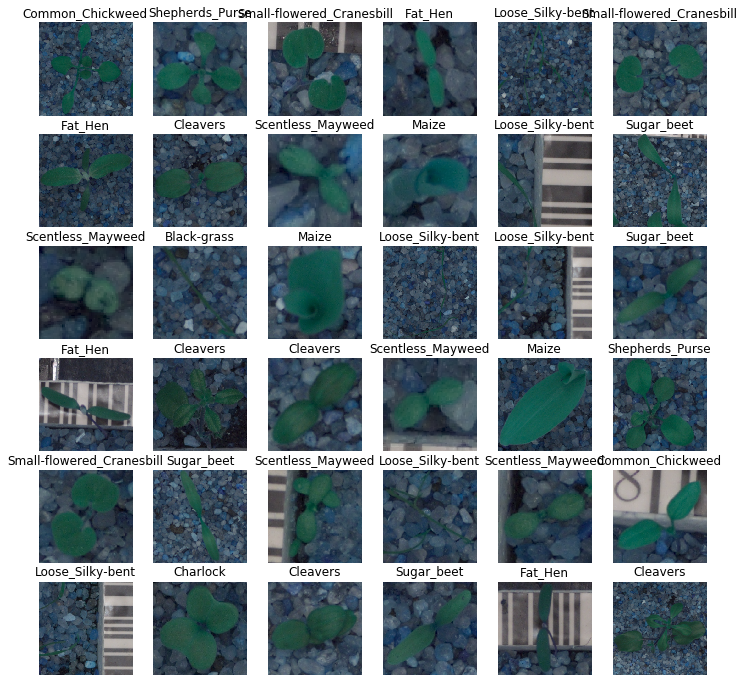

In [76]:
viz_dataset(X_valid_cv, y_valid_cv, classNames, 36)

#### 推倒重来。从数据集加载开始

* 错误总结：  
    - 0. 数据加载：
        - ①无论任何时候，只要加载数据，一定要检查train和val中的数据是否在**同一形状**和**同一范围**。即使数          据是生成器的形式，也必须他妈给我next出一批样例来检查！！！
        - ②keras数据加载别他妈用什么乱七八糟的preprocess_input。就用最基本的方法把图片读进来，然后在aug中处          理。normalize就加个参数：`rescale=1./255`。**连自己加载进来的数据都不知道什么样子的**，训练马勒戈壁          吧训练的一个劲
        - ③**加载完imgPaths记得shuffle一下**，要不然数据读出来都是按顺序的！！！你他妈在前几个类别训练，然后再跑到剩下的类别验证？？
    - 1. 模型构建：  
        - ①在使用pretrained model时，最好加上参数pooling='avg'。这样baseModel最后一层为GAP
        - ②搭建Header时别把Dropout放到Dense(classes)之后，跟白痴一样，就他妈几个神经元还随机失活？
    - 2. 优化过程：
        - SGD确实比RMSProp等高级优化算法收敛慢很多  
    - 3. 迁移学习阶段
        - Header training：不需要用LR schedule。通常用1e-3的学习率train 30个epoch左右。这时候val_acc可能只有           30左右，观察训练曲线可能也会觉得很糟糕，不过不要怕。这个阶段只是为了让fc warm start。
        - Unfreeze training：启用LR Schedule。可以从1e-4的学习率开始train。如果一次Unfreeze所有layer，那就            train 200个左右epoch；若分阶段Unfreeze，则总共train够200个左右就差不多

In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD, RMSprop, Adam
from os.path import join
import os
from datetime import datetime
import sys
from imutils import paths
import numpy as np
sys.path.append("..")
from pyimage.utils import SimpleDatasetLoader, plot_history, rank5_accuracy
from pyimage.preprocess import *
from pyimage.callbacks import TrainingMonitor
from keras.applications import resnet50, inception_resnet_v2, Xception
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

from keras.utils import to_categorical
from pyimage.utils import plot_history
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.models import Model, Input
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb

Using TensorFlow backend.


In [2]:
TRAINROOT = "../Dataset/Seeds/totoal/"
SAVEWEIGHTS='outputs/models/baseline_incepRes_noaug'
OUTPUTPATH = 'outputs/logs/'
BATCHSIZE=32
LR=0.001
SIZEINPUT=299
INPUTSHAPE=(299,299,3)
POOLING = 'avg'

### 下面是第一个dataloader版本。  
* 该版本犯了一个严重的错：未确保训练集和验证集相同的数据范围或者尺寸

In [50]:
def load_dataset(k=7):
    
    def _read_img(filepath, size):
        img = load_img(filepath, target_size=size)
        img = img_to_array(img)
        return img
    
    imgPaths = list(paths.list_images(TRAINROOT))
    np.random.shuffle(imgPaths)
    X = np.zeros((len(imgPaths), SIZEINPUT, SIZEINPUT, 3), dtype='float32')
    processbar = tqdm(imgPaths)
    for i, imgPath in enumerate(processbar):
        img = _read_img(imgPath, (SIZEINPUT, SIZEINPUT))
        x = inception_resnet_v2.preprocess_input(np.expand_dims(img, axis=0))
        X[i] = x  # 这里其实x和X[i]维度不一样
        processbar.update()
    #X = inception_resnet_v2.preprocess_input(X) #对整个数据集的X用preprocess结果不一样...
    y = [x.split(os.path.sep)[-2] for x in imgPaths]
    print('Train Images shape: {} size: {:,}'.format(X.shape, X.size))
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X, y))
    return folds, X, y

def get_one_fold(X, y, num_fold=0):
    if y.shape[-1]!=12:
        y = to_categorical(y, 12)
    train_idx, val_idx = folds[num_fold]
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_valid = X[val_idx]
    y_valid = y[val_idx]
    return X_train, y_train, X_valid, y_valid

In [51]:
folds, X, y = load_dataset()
lb = LabelBinarizer()
y = lb.fit_transform(y)
classNames = lb.classes_
y = y.astype('float32')
print("[INFO] loading fold-1 Dataset...")
X_train, y_train, X_valid, y_valid = get_one_fold(X, y)

aug = ImageDataGenerator(rotation_range=10, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1,
                         brightness_range=[0.5, 1.5],
                         zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode="nearest",
                        )
generator = aug.flow(X_train, y_train, batch_size=BATCHSIZE)


 25%|██▍       | 1177/4750 [00:10<00:25, 142.84it/s]


 48%|████▊     | 2293/4750 [00:19<00:21, 115.99it/s]


 66%|██████▋   | 3157/4750 [00:29<00:26, 61.14it/s]


 79%|███████▉  | 3768/4750 [00:40<00:17, 56.60it/s]


 92%|█████████▏| 4385/4750 [00:49<00:05, 69.83it/s]


100%|██████████| 4750/4750 [00:55<00:00, 55.26it/s]


Train Images shape: (4750, 299, 299, 3) size: 1,273,964,250
[INFO] loading fold-1 Dataset...


### Dataloader 纠正

In [36]:
def _read_img(filepath, size):
        img = load_img(filepath, target_size=size)
        img = img_to_array(img)
        return img
    
def load_dataset(k=7):
    imgPaths = list(paths.list_images(TRAINROOT))
    np.random.shuffle(imgPaths)
    X = []
    processbar = tqdm(imgPaths)
    for i, imgPath in enumerate(processbar):
        img = _read_img(imgPath, (SIZEINPUT, SIZEINPUT))
        X.append(img)
    X = np.array(X)
    y = [x.split(os.path.sep)[-2] for x in imgPaths]
    print('Train Images shape: {} size: {:,}'.format(X.shape, X.size))
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X, y))
    return folds, X, y

def get_one_fold(X, y, num_fold=0):
    if y.shape[-1]!=12:
        y = to_categorical(y, 12)
    train_idx, val_idx = folds[num_fold]
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_valid = X[val_idx]
    y_valid = y[val_idx]
    return X_train, y_train, X_valid, y_valid

In [37]:
folds, X, y = load_dataset()
lb = LabelBinarizer()
y = lb.fit_transform(y)
classNames = lb.classes_
y = y.astype('float32')
print("[INFO] loading fold-1 Dataset...")
X_train, y_train, X_valid, y_valid = get_one_fold(X, y)
aug_train = ImageDataGenerator(
        rescale = 1/255.,
        rotation_range=60, 
        width_shift_range=0.15, 
        height_shift_range=0.15,
        brightness_range=[0.5, 1.5],
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        )
aug_test = ImageDataGenerator(rescale = 1/255.)
generator_train = aug_train.flow(X_train, y_train, batch_size=BATCHSIZE, shuffle=True)
generator_test = aug_test.flow(X_valid, y_valid, batch_size=BATCHSIZE, shuffle=False)


 52%|█████▏    | 2455/4750 [00:19<00:17, 128.28it/s]


100%|██████████| 4750/4750 [00:39<00:00, 121.68it/s]

Train Images shape: (4750, 299, 299, 3) size: 1,273,964,250
[INFO] loading fold-1 Dataset...


In [38]:
def check_generators(trainGen, classNames):
    %matplotlib notebook
    trainX, trainY = trainGen.next()
    fig = plt.figure(figsize=(6,6))
    for tx,ty in zip(trainX, trainY):
        plt.clf()
        plt.imshow(tx)
        plt.title(classNames[ty.argmax()])
        plt.axis('off')
        fig.canvas.draw()
        plt.pause(0.3)

<IPython.core.display.Javascript object>


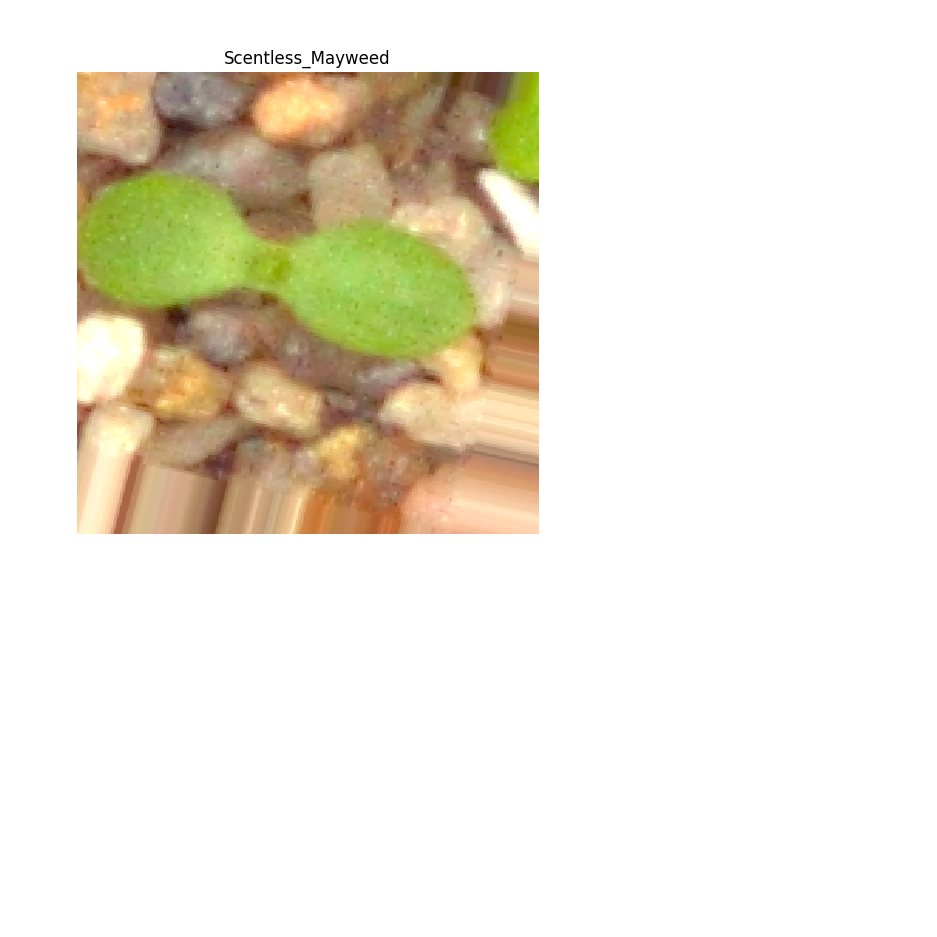

KeyboardInterrupt: 

In [39]:
check_generators(generator_train, classNames)

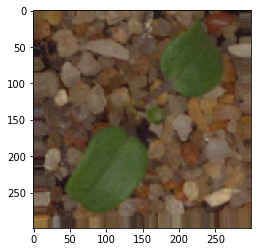

In [15]:
plt.imshow(ct/255)

#### 检查数据集

##### 注意：直接训练（不使用Aug），似乎train不起来。准确率只能达到四十多

```Python
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = SAVEWEIGHTS+"_fold" + str(j) + "_weights.h5"
    #callbacks = get_callbacks(OUTPUTPATH, name_weights, patience_lr=10, k=j)
    callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]
    #generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model_v2()
    model.fit( X_train_cv, y_train_cv, batch_size=BATCHSIZE,
               epochs=10,
               shuffle=True,
               verbose=1,
               validation_data = (X_valid_cv, y_valid_cv),
               callbacks = callbacks
             )
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
```

### Feature Extractor  
* 直接使用ImageNet上面的权重进行feature extract + Logistic Regression可以达到84的f1 score  
* 注意：classification_report显示出第一种植物Black-grass的区分度非常低。或许可以考虑使用GAN生成一些

In [7]:
baseModel = inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                                  input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))

In [8]:
X_features = baseModel.predict(X).reshape(X.shape[0], -1)
y = y.argmax(axis=1)
for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j)
    X_train_cv = X_features[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X_features[val_idx]
    y_valid_cv= y[val_idx]
    
    logreg = LogisticRegression()
    logreg.fit(X_train_cv, y_train_cv)
    preds_val = logreg.predict(X_valid_cv)

    print(classification_report(y_valid_cv, preds_val, target_names=classNames))


Fold  0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.60      0.47      0.53        38
                 Charlock       0.91      0.93      0.92        56
                 Cleavers       0.87      0.83      0.85        41
         Common_Chickweed       0.85      0.93      0.89        88
             Common_wheat       0.79      0.72      0.75        32
                  Fat_Hen       0.77      0.75      0.76        68
         Loose_Silky-bent       0.74      0.88      0.81        94
                    Maize       0.97      0.94      0.95        32
        Scentless_Mayweed       0.85      0.91      0.88        74
          Shepherds_Purse       0.78      0.64      0.70        33
Small-flowered_Cranesbill       0.98      0.90      0.94        71
               Sugar_beet       0.88      0.80      0.84        55

                micro avg       0.83      0.83      0.83       682
                macro avg       0.83      0.81      0.82    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.57      0.34      0.43        38
                 Charlock       0.90      0.95      0.92        56
                 Cleavers       0.93      0.93      0.93        41
         Common_Chickweed       0.84      0.85      0.85        88
             Common_wheat       0.92      0.75      0.83        32
                  Fat_Hen       0.80      0.78      0.79        68
         Loose_Silky-bent       0.74      0.89      0.81        94
                    Maize       0.96      0.78      0.86        32
        Scentless_Mayweed       0.89      0.95      0.92        74
          Shepherds_Purse       0.85      0.70      0.77        33
Small-flowered_Cranesbill       0.90      0.92      0.91        71
               Sugar_beet       0.85      0.93      0.89        55

                micro avg       0.84      0.84      0.84       682
                macro avg       0.85      0.81      0.82    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.63      0.45      0.52        38
                 Charlock       0.90      0.95      0.92        56
                 Cleavers       1.00      0.78      0.88        41
         Common_Chickweed       0.77      0.91      0.83        87
             Common_wheat       0.89      0.78      0.83        32
                  Fat_Hen       0.86      0.84      0.85        68
         Loose_Silky-bent       0.81      0.90      0.85        94
                    Maize       0.89      0.75      0.81        32
        Scentless_Mayweed       0.79      0.85      0.82        74
          Shepherds_Purse       0.83      0.61      0.70        33
Small-flowered_Cranesbill       0.91      0.99      0.95        71
               Sugar_beet       0.92      0.89      0.91        55

                micro avg       0.84      0.84      0.84       681
                macro avg       0.85      0.81      0.82    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.61      0.37      0.46        38
                 Charlock       0.87      0.95      0.91        56
                 Cleavers       0.89      0.76      0.82        41
         Common_Chickweed       0.81      0.86      0.83        87
             Common_wheat       0.93      0.88      0.90        32
                  Fat_Hen       0.85      0.78      0.82        68
         Loose_Silky-bent       0.73      0.89      0.81        93
                    Maize       0.96      0.84      0.90        32
        Scentless_Mayweed       0.80      0.86      0.83        74
          Shepherds_Purse       0.74      0.61      0.67        33
Small-flowered_Cranesbill       0.90      0.97      0.93        71
               Sugar_beet       0.88      0.82      0.85        55

                micro avg       0.83      0.83      0.83       680
                macro avg       0.83      0.80      0.81    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.50      0.41      0.45        37
                 Charlock       0.96      0.93      0.95        56
                 Cleavers       0.94      0.83      0.88        41
         Common_Chickweed       0.86      0.92      0.89        87
             Common_wheat       0.92      0.77      0.84        31
                  Fat_Hen       0.87      0.90      0.88        68
         Loose_Silky-bent       0.76      0.90      0.82        93
                    Maize       0.90      0.84      0.87        31
        Scentless_Mayweed       0.87      0.89      0.88        74
          Shepherds_Purse       0.77      0.73      0.75        33
Small-flowered_Cranesbill       0.88      0.92      0.90        71
               Sugar_beet       0.98      0.84      0.90        55

                micro avg       0.85      0.85      0.85       677
                macro avg       0.85      0.82      0.83    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.50      0.49      0.49        37
                 Charlock       0.87      0.98      0.92        55
                 Cleavers       0.94      0.80      0.87        41
         Common_Chickweed       0.78      0.89      0.83        87
             Common_wheat       0.80      0.77      0.79        31
                  Fat_Hen       0.87      0.76      0.81        68
         Loose_Silky-bent       0.78      0.85      0.81        93
                    Maize       0.93      0.90      0.92        31
        Scentless_Mayweed       0.82      0.85      0.83        73
          Shepherds_Purse       0.80      0.61      0.69        33
Small-flowered_Cranesbill       0.88      0.94      0.91        71
               Sugar_beet       0.87      0.71      0.78        55

                micro avg       0.82      0.82      0.82       675
                macro avg       0.82      0.80      0.80    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                           precision    recall  f1-score   support

              Black-grass       0.72      0.35      0.47        37
                 Charlock       0.96      0.93      0.94        55
                 Cleavers       0.83      0.73      0.78        41
         Common_Chickweed       0.90      0.89      0.89        87
             Common_wheat       0.96      0.77      0.86        31
                  Fat_Hen       0.83      0.81      0.82        67
         Loose_Silky-bent       0.73      0.95      0.82        93
                    Maize       0.97      0.94      0.95        31
        Scentless_Mayweed       0.79      0.85      0.82        73
          Shepherds_Purse       0.77      0.73      0.75        33
Small-flowered_Cranesbill       0.92      0.94      0.93        70
               Sugar_beet       0.88      0.93      0.90        55

                micro avg       0.85      0.85      0.85       673
                macro avg       0.86      0.82      0.83    

### Finetune + Augmentation  
* 方便起见，接下来只是用一个fold进行训练。最后再使用交叉验证  
* 关于Keras Augmentation的介绍见：  
https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad  
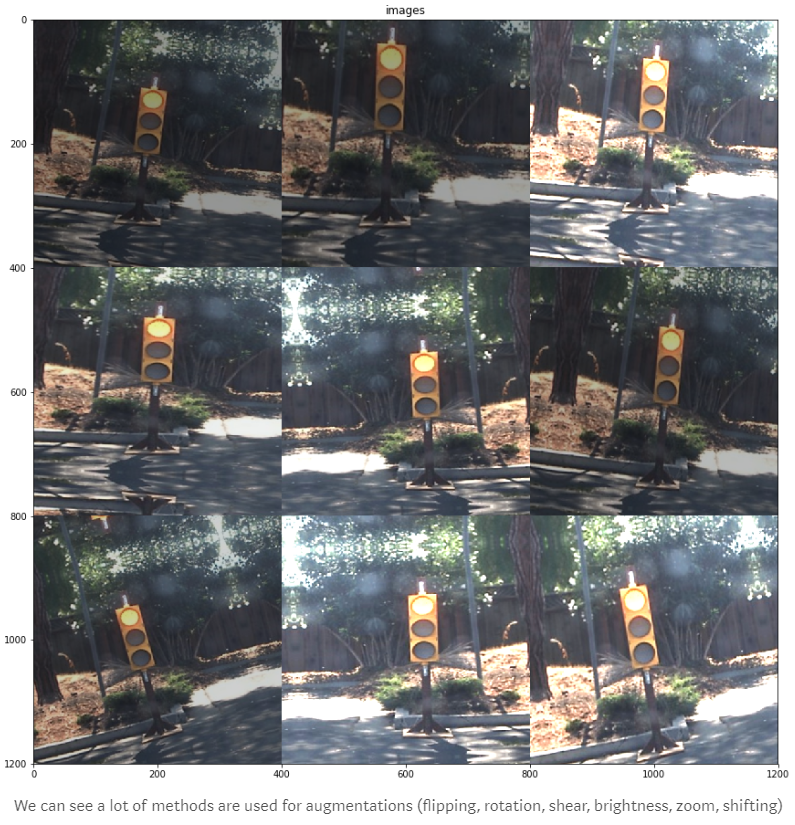

In [19]:
from keras import backend as K
K.clear_session()

In [14]:
print("[INFO] building model...")
basic_model = Xception(include_top=False, weights='imagenet', pooling='avg')

for layer in basic_model.layers:
    layer.trainable = False

input_tensor = basic_model.input
# build top
x = basic_model.output
x = Dropout(.5)(x)  ##
x = Dense(12, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer=RMSprop(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

print("[INFO] training header...")
H=model.fit_generator(generator, epochs=40, 
                    validation_data=(X_valid, y_valid),
                    #callbacks=[tensorboard],
                    #workers=4,
                    verbose=1)
plot_history(H, 40, True)

[INFO] building model...
[INFO] training header...
Epoch 1/40
102/102 [==============================] - 63s 619ms/step - loss: 1.9063 - acc: 0.4069 - val_loss: 1.9611 - val_acc: 0.2974
Epoch 2/40
102/102 [==============================] - 59s 582ms/step - loss: 1.3490 - acc: 0.5969 - val_loss: 1.9390 - val_acc: 0.3248
Epoch 3/40
102/102 [==============================] - 59s 578ms/step - loss: 1.1390 - acc: 0.6513 - val_loss: 1.9117 - val_acc: 0.2774
Epoch 4/40
102/102 [==============================] - 59s 579ms/step - loss: 0.9980 - acc: 0.7028 - val_loss: 2.1170 - val_acc: 0.2555
Epoch 5/40
102/102 [==============================] - 59s 579ms/step - loss: 0.9098 - acc: 0.7185 - val_loss: 1.9178 - val_acc: 0.3449
Epoch 6/40
 31/102 [========>.....................] - ETA: 33s - loss: 0.8929 - acc: 0.7093

KeyboardInterrupt: 

* 回到自己的模型

In [31]:
print("[INFO] building model...")
baseModel = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg',
            input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))
for layer in baseModel.layers:
    layer.trainable=False
    
x = baseModel.output
x = Dropout(0.5)(x)  ## 别他妈把dropout放在12的dense上！！
#x = Flatten()(x) #注意：使用GlobalAveragePooling2D时，输出即为2D Tensor，无需再用Flatten
x = Dense(12, activation='softmax')(x)

model = Model(inputs=baseModel.inputs, outputs=x)


opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=RMSprop(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

[INFO] building model...


[INFO] training network...
Epoch 1/30
127/127 [==============================] - 75s 587ms/step - loss: 2.0663 - acc: 0.3167 - val_loss: 13.1311 - val_acc: 0.1320
Epoch 2/30
127/127 [==============================] - 71s 558ms/step - loss: 1.5973 - acc: 0.5086 - val_loss: 13.4080 - val_acc: 0.1129
Epoch 3/30
127/127 [==============================] - 71s 559ms/step - loss: 1.3940 - acc: 0.5657 - val_loss: 13.2622 - val_acc: 0.1188
Epoch 4/30
127/127 [==============================] - 70s 550ms/step - loss: 1.2975 - acc: 0.5901 - val_loss: 14.0088 - val_acc: 0.1290
Epoch 5/30
127/127 [==============================] - 70s 550ms/step - loss: 1.2021 - acc: 0.6063 - val_loss: 13.9559 - val_acc: 0.1276
Epoch 6/30
127/127 [==============================] - 69s 540ms/step - loss: 1.1408 - acc: 0.6361 - val_loss: 12.9249 - val_acc: 0.1202
Epoch 7/30
127/127 [==============================] - 69s 544ms/step - loss: 1.1009 - acc: 0.6346 - val_loss: 13.2189 - val_acc: 0.1334
Epoch 8/30
127/127 [=

<IPython.core.display.Javascript object>


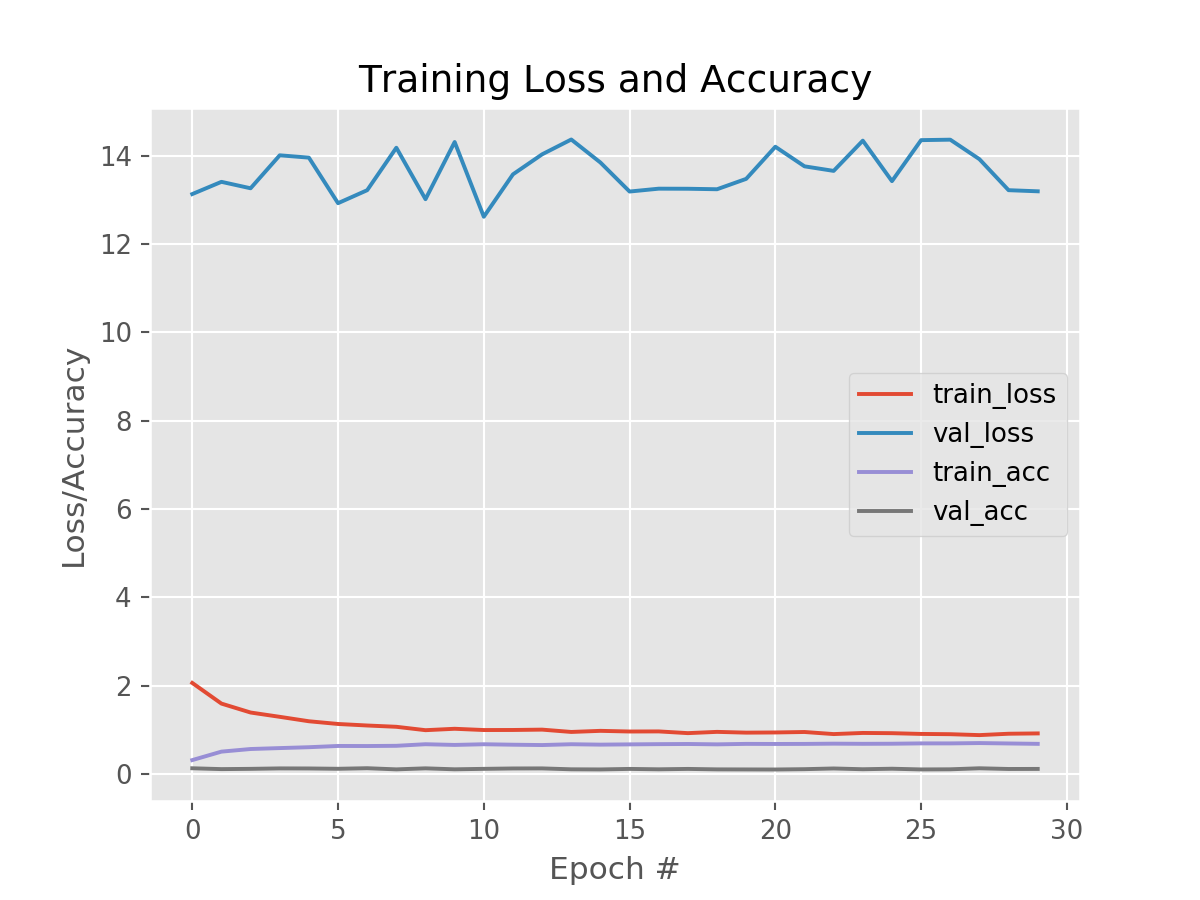

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        41
           3       0.17      0.35      0.23        88
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        94
           7       0.00      0.00      0.00        32
           8       0.10      0.65      0.17        74
           9       0.00      0.00      0.00        33
          10       0.33      0.01      0.03        71
          11       0.00      0.00      0.00        55

   micro avg       0.12      0.12      0.12       682
   macro avg       0.05      0.08      0.04       682
weighted avg       0.07      0.12      0.05       682



In [32]:
print("[INFO] training network...")
WARM_START_EPOCHS = 30
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=WARM_START_EPOCHS)
print("[INFO] evaluating...")
plot_history(H, WARM_START_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1)))
model.save_weights("warmstart2.h5")
#name_weights = SAVEWEIGHTS+"_" + str(j) + "_weights.h5"
#callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]

### Unfreeze Some Layers from the BOTTOM ones

In [26]:
for (i, layer) in enumerate(model.layers):
    print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	BatchNormalization
[INFO] 3	Activation
[INFO] 4	Conv2D
[INFO] 5	BatchNormalization
[INFO] 6	Activation
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	BatchNormalization
[INFO] 13	Activation
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	Activation
[INFO] 17	MaxPooling2D
[INFO] 18	Conv2D
[INFO] 19	BatchNormalization
[INFO] 20	Activation
[INFO] 21	Conv2D
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	BatchNormalization
[INFO] 25	Activation
[INFO] 26	Activation
[INFO] 27	AveragePooling2D
[INFO] 28	Conv2D
[INFO] 29	Conv2D
[INFO] 30	Conv2D
[INFO] 31	Conv2D
[INFO] 32	BatchNormalization
[INFO] 33	BatchNormalization
[INFO] 34	BatchNormalization
[INFO] 35	BatchNormalization
[INFO] 36	Activation
[INFO] 37	Activation
[INFO] 38	Activation
[INFO] 39	Activation
[INFO] 40	Concatenate
[INFO] 41	Conv2D
[INFO] 42	BatchNormalization
[INFO] 43	Activation
[INFO] 44	Conv2D
[INFO]

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

In [14]:
from keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True)

In [15]:
model.layers.index(model.get_layer(name='conv2d_276'))

267

model.save_weights('21_32.hdf5')

In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-4
    if epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def recompile_model(phaseLR, unfreezeAfter):
    print("[INFO] recompiling model...")
    print("[INFO] unfreezing layers after {}".format(model.layers[unfreezeAfter].name))
    for layer in model.layers[unfreezeAfter:]:
        layer.W_regularizer = l2(1e-2)
        layer.trainable = True
    opt = RMSprop(lr=phaseLR)
    model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])

Learning rate:  0.0001
[INFO] recompiling model...
[INFO] unfreezing layers after block17_14_ac
[INFO] continue training for phase 2...
Epoch 31/60
Learning rate:  0.0001
127/127 [==============================] - 65s 513ms/step - loss: 0.4400 - acc: 0.8514 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 32/60
Learning rate:  0.0001
127/127 [==============================] - 48s 380ms/step - loss: 0.2564 - acc: 0.9085 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 33/60
Learning rate:  0.0001
127/127 [==============================] - 48s 380ms/step - loss: 0.2044 - acc: 0.9326 - val_loss: 13.7947 - val_acc: 0.1364
Epoch 34/60
Learning rate:  0.0001
127/127 [==============================] - 48s 382ms/step - loss: 0.1611 - acc: 0.9390 - val_loss: 13.8223 - val_acc: 0.1393
Epoch 35/60
Learning rate:  0.0001
127/127 [==============================] - 48s 378ms/step - loss: 0.1241 - acc: 0.9547 - val_loss: 13.8965 - val_acc: 0.1378
Epoch 36/60
Learning rate:  0.0001
127/127 [====================

<IPython.core.display.Javascript object>


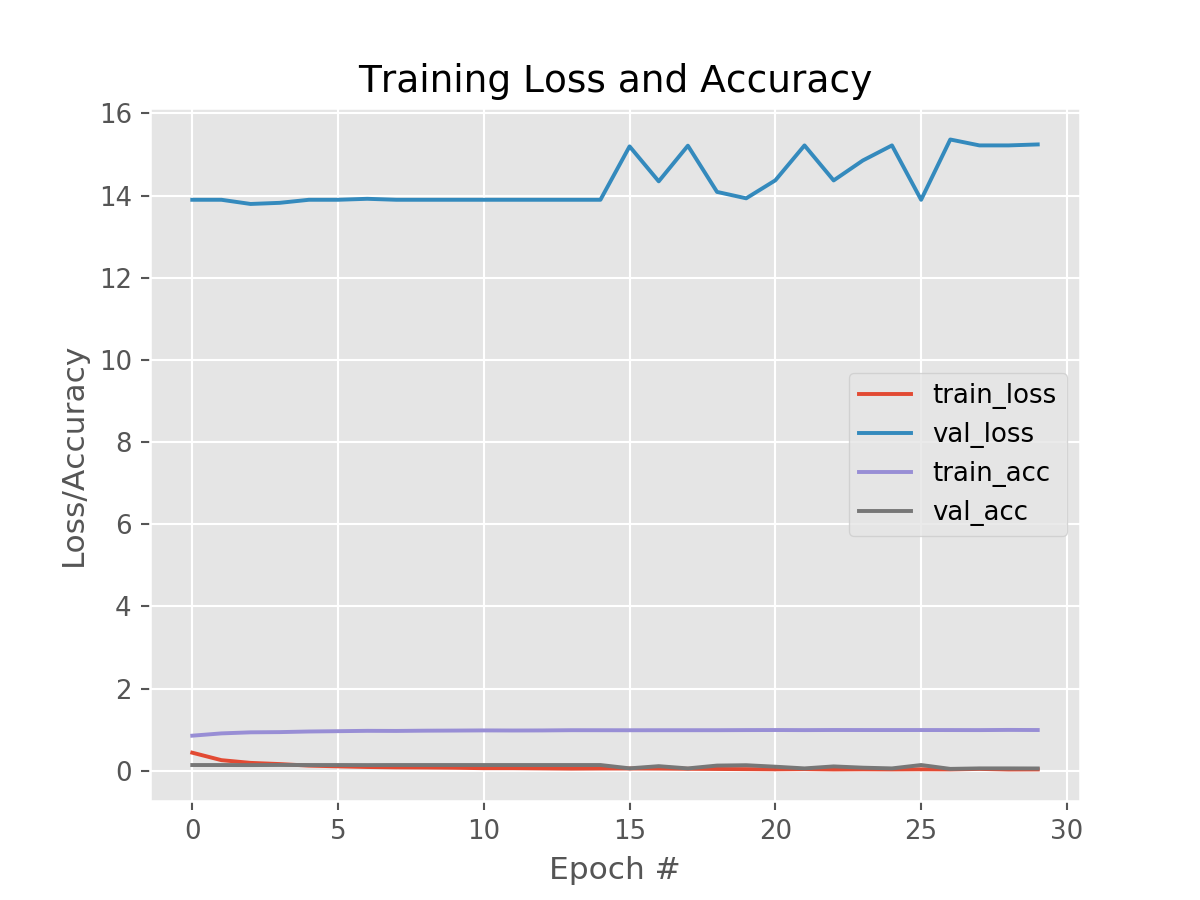

                           precision    recall  f1-score   support

              Black-grass       0.06      0.66      0.10        38
                 Charlock       0.00      0.00      0.00        56
                 Cleavers       0.00      0.00      0.00        41
         Common_Chickweed       0.00      0.00      0.00        88
             Common_wheat       0.05      0.38      0.09        32
                  Fat_Hen       0.00      0.00      0.00        68
         Loose_Silky-bent       0.00      0.00      0.00        94
                    Maize       0.00      0.00      0.00        32
        Scentless_Mayweed       0.00      0.00      0.00        74
          Shepherds_Purse       0.00      0.00      0.00        33
Small-flowered_Cranesbill       0.00      0.00      0.00        71
               Sugar_beet       0.00      0.00      0.00        55

                micro avg       0.05      0.05      0.05       682
                macro avg       0.01      0.09      0.02    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
PHASE2_EPOCHS = 60
recompile_model(phaseLR=lr_schedule(WARM_START_EPOCHS), unfreezeAfter=498)
print('[INFO] continue training for phase 2...')

ckpt = ModelCheckpoint("finetune_phase2.h5", save_best_only=True, monitor='val_loss', mode='min', period=2)
lrscheduler = LearningRateScheduler(lr_schedule)
callbacks = [lrscheduler, ckpt]
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=PHASE2_EPOCHS, 
                        callbacks=callbacks, initial_epoch=WARM_START_EPOCHS, workers=8)
print("[INFO] evaluating...")
plot_history(H, PHASE2_EPOCHS-WARM_START_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))

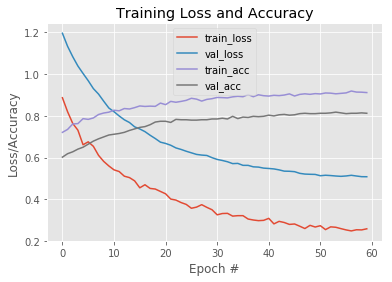

                           precision    recall  f1-score   support

              Black-grass       0.50      0.10      0.16        31
                 Charlock       0.95      0.87      0.91        45
                 Cleavers       0.76      0.85      0.80        33
         Common_Chickweed       0.80      0.91      0.85        70
             Common_wheat       0.96      0.85      0.90        26
                  Fat_Hen       0.91      0.76      0.83        55
         Loose_Silky-bent       0.70      0.99      0.82        75
                    Maize       1.00      0.77      0.87        26
        Scentless_Mayweed       0.82      0.80      0.81        59
          Shepherds_Purse       0.46      0.41      0.43        27
Small-flowered_Cranesbill       0.83      1.00      0.90        57
               Sugar_beet       0.97      0.86      0.92        44

                micro avg       0.81      0.81      0.81       548
                macro avg       0.80      0.76      0.77    

<Figure size 432x288 with 0 Axes>

In [31]:
# plot_history(H, PHASE2_EPOCHS-WARM_START_EPOCHS, viz=True)
# preds = model.predict(X_valid)
# print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))
# #model.save_weights('finetune_phase2_final.h5')

Learning rate:  0.0001
[INFO] recompiling model...
[INFO] unfreezing layers after conv2d_73
[INFO] continue training for phase 3...
Epoch 61/100
Learning rate:  0.0001
127/127 [==============================] - 92s 721ms/step - loss: 0.0669 - acc: 0.9820 - val_loss: 15.3078 - val_acc: 0.0499
Epoch 62/100
Learning rate:  0.0001
127/127 [==============================] - 67s 528ms/step - loss: 0.0593 - acc: 0.9828 - val_loss: 15.2200 - val_acc: 0.0557
Epoch 63/100
Learning rate:  0.0001
127/127 [==============================] - 67s 526ms/step - loss: 0.0432 - acc: 0.9884 - val_loss: 14.3692 - val_acc: 0.1085
Epoch 64/100
Learning rate:  0.0001
127/127 [==============================] - 67s 527ms/step - loss: 0.0425 - acc: 0.9845 - val_loss: 15.3618 - val_acc: 0.0469
Epoch 65/100
Learning rate:  0.0001
127/127 [==============================] - 67s 530ms/step - loss: 0.0454 - acc: 0.9860 - val_loss: 15.3618 - val_acc: 0.0469
Epoch 66/100
Learning rate:  0.0001
127/127 [==================

<IPython.core.display.Javascript object>


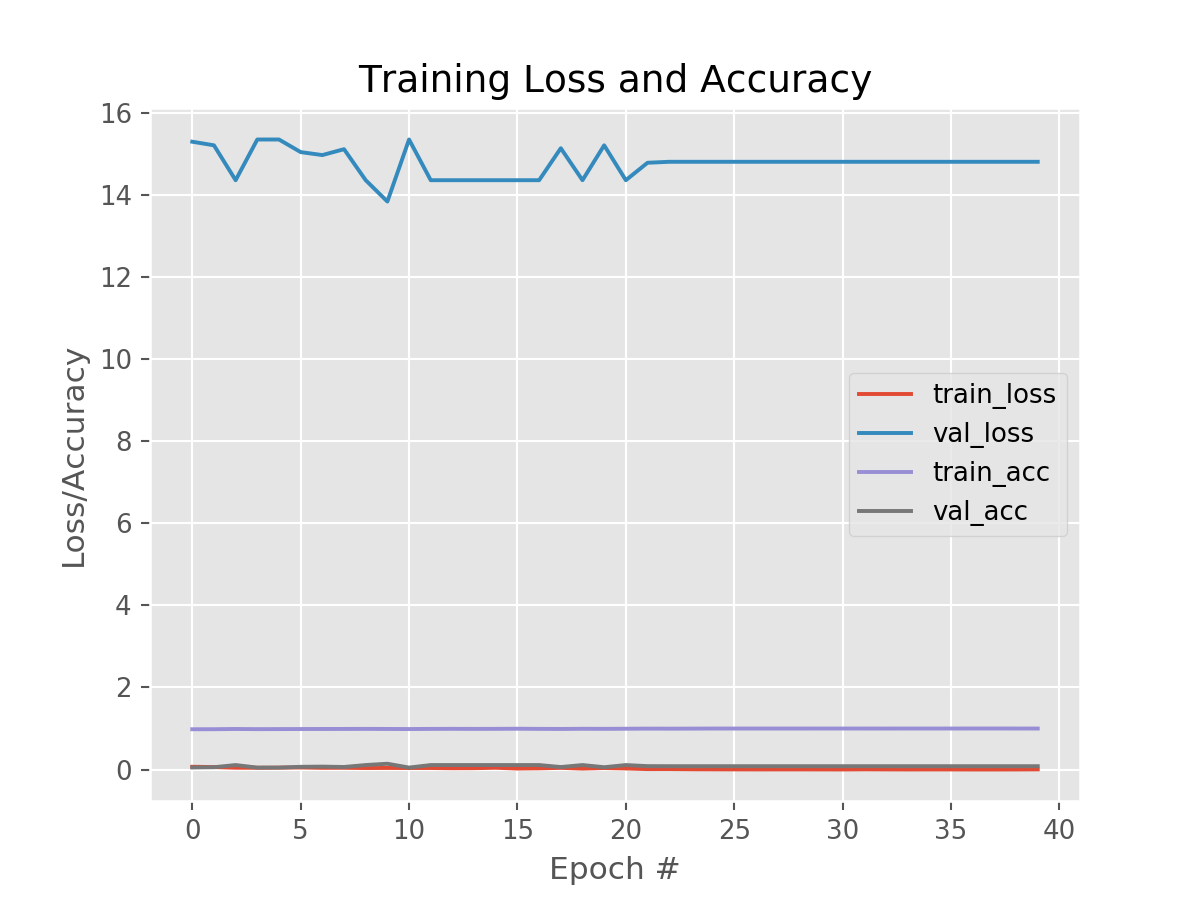

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        38
                 Charlock       0.00      0.00      0.00        56
                 Cleavers       0.00      0.00      0.00        41
         Common_Chickweed       0.00      0.00      0.00        88
             Common_wheat       0.00      0.00      0.00        32
                  Fat_Hen       0.00      0.00      0.00        68
         Loose_Silky-bent       0.00      0.00      0.00        94
                    Maize       0.00      0.00      0.00        32
        Scentless_Mayweed       0.00      0.00      0.00        74
          Shepherds_Purse       0.00      0.00      0.00        33
Small-flowered_Cranesbill       0.00      0.00      0.00        71
               Sugar_beet       0.08      1.00      0.15        55

                micro avg       0.08      0.08      0.08       682
                macro avg       0.01      0.08      0.01    

In [35]:
## Phase3的训练不知道为何反而让模型性能下降了..
PHASE3_EPOCHS = 100
recompile_model(phaseLR=lr_schedule(PHASE2_EPOCHS), unfreezeAfter=267)
print('[INFO] continue training for phase 3...')

ckpt = ModelCheckpoint("finetune_phase3.h5", save_best_only=True, monitor='val_loss', mode='min', period=2)
lrscheduler = LearningRateScheduler(lr_schedule)
callbacks = [lrscheduler, ckpt]
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=PHASE3_EPOCHS, 
                        callbacks=callbacks, initial_epoch=PHASE2_EPOCHS, workers=8)
print("[INFO] evaluating...")
plot_history(H, PHASE3_EPOCHS-PHASE2_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))
model.save_weights('finetune_phase3_final.h5')

[INFO] loading weights...
Learning rate:  1e-05
[INFO] recompiling model...
[INFO] unfreezing layers after input_1
[INFO] continue training for phase 4...
Epoch 101/150
Learning rate:  1e-05
127/127 [==============================] - 129s 1s/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0944 - val_acc: 0.9897
Epoch 102/150
Learning rate:  1e-05
127/127 [==============================] - 90s 709ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.1067 - val_acc: 0.9897
Epoch 103/150
Learning rate:  1e-05
127/127 [==============================] - 90s 709ms/step - loss: 4.5877e-04 - acc: 0.9998 - val_loss: 0.0985 - val_acc: 0.9897
Epoch 104/150
Learning rate:  1e-05
127/127 [==============================] - 90s 709ms/step - loss: 0.0031 - acc: 0.9990 - val_loss: 0.1154 - val_acc: 0.9912
Epoch 105/150
Learning rate:  1e-05
127/127 [==============================] - 90s 709ms/step - loss: 3.2472e-04 - acc: 1.0000 - val_loss: 0.1074 - val_acc: 0.9912
Epoch 106/150
Learning rate:  1e-05
127

<IPython.core.display.Javascript object>


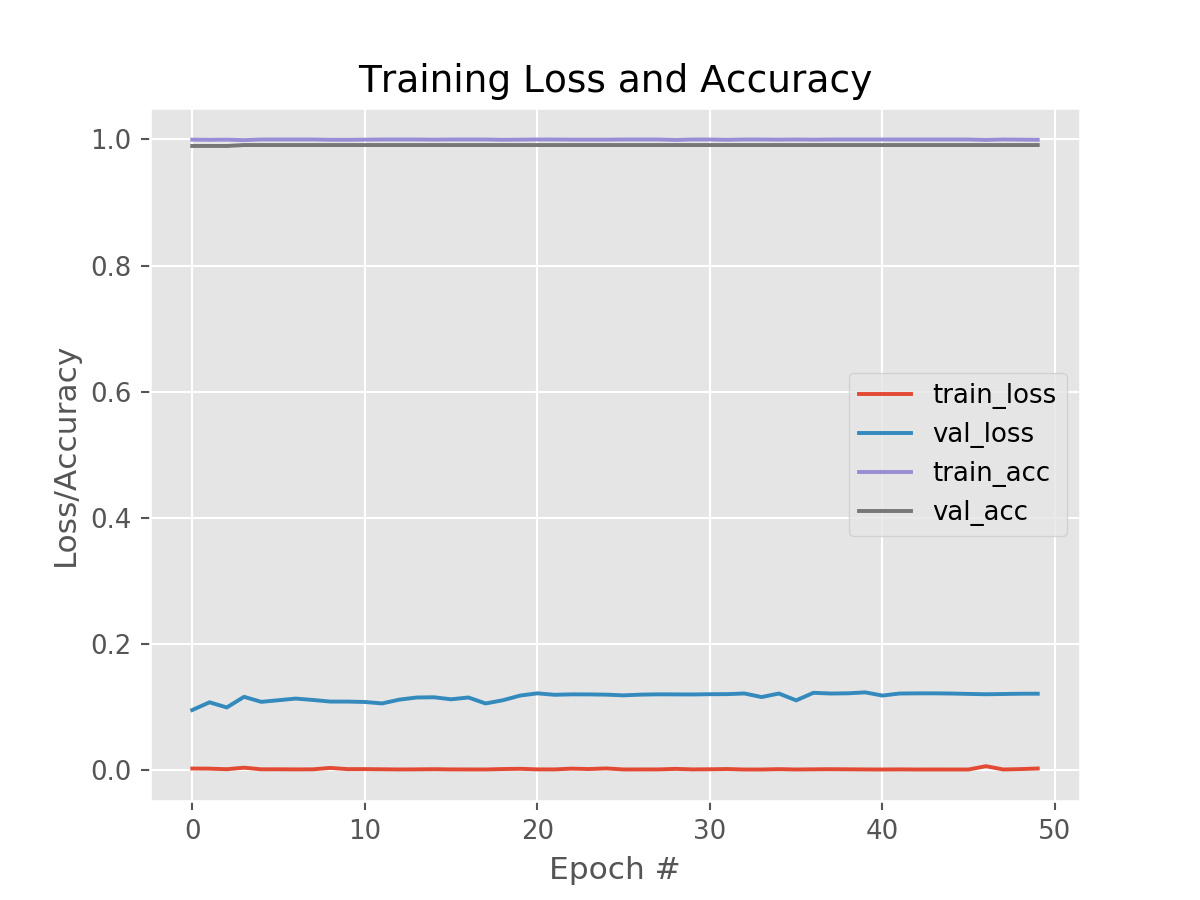

                           precision    recall  f1-score   support

              Black-grass       1.00      0.87      0.93        38
                 Charlock       1.00      1.00      1.00        56
                 Cleavers       1.00      1.00      1.00        41
         Common_Chickweed       1.00      1.00      1.00        88
             Common_wheat       1.00      0.97      0.98        32
                  Fat_Hen       1.00      1.00      1.00        68
         Loose_Silky-bent       0.97      1.00      0.98        94
                    Maize       1.00      1.00      1.00        32
        Scentless_Mayweed       1.00      1.00      1.00        74
          Shepherds_Purse       1.00      1.00      1.00        33
Small-flowered_Cranesbill       1.00      1.00      1.00        71
               Sugar_beet       0.95      1.00      0.97        55

                micro avg       0.99      0.99      0.99       682
                macro avg       0.99      0.99      0.99    

In [36]:
print("[INFO] loading weights...")
#model.load_weights('finetune_phase2_final.h5')
PHASE4_EPOCHS = 150
recompile_model(phaseLR=lr_schedule(PHASE3_EPOCHS), unfreezeAfter=0)
print('[INFO] continue training for phase 4...')

ckpt = ModelCheckpoint("finetune_phase4.h5", save_best_only=True, monitor='val_loss', mode='min', period=2)
lrscheduler = LearningRateScheduler(lr_schedule)
callbacks = [lrscheduler, ckpt]
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=PHASE4_EPOCHS, 
                        callbacks=callbacks, initial_epoch=PHASE3_EPOCHS, workers=8)
print("[INFO] evaluating...")
plot_history(H, PHASE4_EPOCHS-PHASE3_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))
model.save_weights('finetune_phase4_final.h5')

In [7]:
print("[INFO] building model...")
baseModel = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg',
            input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))
for layer in baseModel.layers:
    layer.trainable=False
    
x = baseModel.output
x = Dropout(0.5)(x)  ## 别他妈把dropout放在12的dense上！！
#x = Flatten()(x) #注意：使用GlobalAveragePooling2D时，输出即为2D Tensor，无需再用Flatten
x = Dense(12, activation='softmax')(x)

model = Model(inputs=baseModel.inputs, outputs=x)


opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=RMSprop(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

[INFO] building model...


In [8]:
print("[INFO] training network...")
WARM_START_EPOCHS = 30
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=WARM_START_EPOCHS)
print("[INFO] evaluating...")
plot_history(H, WARM_START_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1)))
model.save_weights("warmstart_ex2.h5")
#name_weights = SAVEWEIGHTS+"_" + str(j) + "_weights.h5"
#callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]

[INFO] training network...
Epoch 1/30
127/127 [==============================] - 73s 576ms/step - loss: 2.0822 - acc: 0.3034 - val_loss: 14.1957 - val_acc: 0.1041
Epoch 2/30
 35/127 [=======>......................] - ETA: 45s - loss: 1.7222 - acc: 0.4375

KeyboardInterrupt: 

In [ ]:
#model.load_weights('finetune_phase2_final.h5')
PHASE2_EPOCHS = 150
recompile_model(phaseLR=lr_schedule(WARM_START_EPOCHS), unfreezeAfter=0)
print('[INFO] continue training(finetune)...')

ckpt = ModelCheckpoint("finetune_ex2.h5", save_best_only=True, monitor='val_loss', mode='min', period=2)
lrscheduler = LearningRateScheduler(lr_schedule)
callbacks = [lrscheduler, ckpt]
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=PHASE2_EPOCHS, 
                        callbacks=callbacks, initial_epoch=WARM_START_EPOCHS, workers=8)
print("[INFO] evaluating...")
plot_history(H, PHASE2_EPOCHS-WARM_START_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))
model.save_weights('finetune_ex2_final.h5')

Learning rate:  0.0001
[INFO] recompiling model...
[INFO] unfreezing layers after input_1
[INFO] continue training(finetune)...
Epoch 31/150
Learning rate:  0.0001
127/127 [==============================] - 125s 986ms/step - loss: 0.4262 - acc: 0.8607 - val_loss: 0.1984 - val_acc: 0.9370
Epoch 32/150
Learning rate:  0.0001
127/127 [==============================] - 90s 706ms/step - loss: 0.2204 - acc: 0.9257 - val_loss: 0.1450 - val_acc: 0.9633
Epoch 33/150
Learning rate:  0.0001
127/127 [==============================] - 89s 704ms/step - loss: 0.1487 - acc: 0.9498 - val_loss: 0.1544 - val_acc: 0.9560
Epoch 34/150
Learning rate:  0.0001
127/127 [==============================] - 90s 707ms/step - loss: 0.1188 - acc: 0.9594 - val_loss: 0.1512 - val_acc: 0.9575
Epoch 35/150
Learning rate:  0.0001
 31/127 [======>.......................] - ETA: 1:05 - loss: 0.0828 - acc: 0.9708

## 1_14夜第二组实验

In [ ]:
print("[INFO] building model...")
baseModel = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg',
            input_tensor=Input(shape=(SIZEINPUT,SIZEINPUT,3)))
for layer in baseModel.layers:
    layer.trainable=False
    
x = baseModel.output
x = Dropout(0.5)(x)  ## 别他妈把dropout放在12的dense上！！
#x = Flatten()(x) #注意：使用GlobalAveragePooling2D时，输出即为2D Tensor，无需再用Flatten
x = Dense(12, activation='softmax')(x)

model = Model(inputs=baseModel.inputs, outputs=x)


opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=RMSprop(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
print("[INFO] training network...")
WARM_START_EPOCHS = 30
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=WARM_START_EPOCHS)
print("[INFO] evaluating...")
plot_history(H, WARM_START_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1)))
model.save_weights("warmstart_ex3.h5")
#name_weights = SAVEWEIGHTS+"_" + str(j) + "_weights.h5"
#callbacks = [ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')]
#model.load_weights('finetune_phase2_final.h5')

PHASE2_EPOCHS = 150
recompile_model(phaseLR=lr_schedule(WARM_START_EPOCHS), unfreezeAfter=0)
print('[INFO] continue training(finetune)...')

ckpt = ModelCheckpoint("finetune_ex3.h5", save_best_only=True, monitor='val_loss', mode='min', period=2)
lrscheduler = LearningRateScheduler(lr_schedule)
callbacks = [lrscheduler, ckpt]
H = model.fit_generator(generator, validation_data=(X_valid, y_valid), 
                    steps_per_epoch=len(X_train)//BATCHSIZE, epochs=PHASE2_EPOCHS, 
                        callbacks=callbacks, initial_epoch=WARM_START_EPOCHS, workers=8)
print("[INFO] evaluating...")
plot_history(H, PHASE2_EPOCHS-WARM_START_EPOCHS, viz=True)
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))
model.save_weights('finetune_ex3_final.h5')

### 1_14夜结果测评

#### 实验一   
实验一的数据H被覆盖了，无法绘制training curve

In [18]:
model.load_weights('finetune_ex2_final.h5')
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))

                           precision    recall  f1-score   support

              Black-grass       1.00      0.97      0.99        38
                 Charlock       1.00      1.00      1.00        56
                 Cleavers       1.00      1.00      1.00        41
         Common_Chickweed       1.00      1.00      1.00        88
             Common_wheat       1.00      1.00      1.00        32
                  Fat_Hen       1.00      1.00      1.00        68
         Loose_Silky-bent       0.99      1.00      0.99        94
                    Maize       1.00      1.00      1.00        32
        Scentless_Mayweed       1.00      1.00      1.00        74
          Shepherds_Purse       1.00      1.00      1.00        33
Small-flowered_Cranesbill       1.00      1.00      1.00        71
               Sugar_beet       1.00      1.00      1.00        55

                micro avg       1.00      1.00      1.00       682
                macro avg       1.00      1.00      1.00    

#### 实验二：

                           precision    recall  f1-score   support

              Black-grass       1.00      1.00      1.00        38
                 Charlock       1.00      1.00      1.00        56
                 Cleavers       1.00      1.00      1.00        41
         Common_Chickweed       1.00      1.00      1.00        88
             Common_wheat       1.00      1.00      1.00        32
                  Fat_Hen       1.00      1.00      1.00        68
         Loose_Silky-bent       1.00      1.00      1.00        94
                    Maize       1.00      1.00      1.00        32
        Scentless_Mayweed       1.00      1.00      1.00        74
          Shepherds_Purse       1.00      1.00      1.00        33
Small-flowered_Cranesbill       1.00      1.00      1.00        71
               Sugar_beet       1.00      1.00      1.00        55

                micro avg       1.00      1.00      1.00       682
                macro avg       1.00      1.00      1.00    

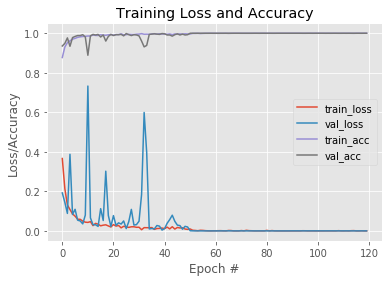

<Figure size 432x288 with 0 Axes>

In [17]:
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))
plot_history(H, PHASE2_EPOCHS-WARM_START_EPOCHS, viz=True)

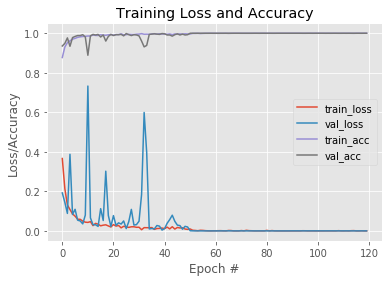

In [19]:
plot_history(H, PHASE2_EPOCHS-WARM_START_EPOCHS, fname="best_model_inceptres.png")

In [44]:
preds = model.predict(X_valid)
print(classification_report(y_valid.argmax(axis=1),preds.argmax(axis=1), target_names=classNames))

                           precision    recall  f1-score   support

              Black-grass       1.00      1.00      1.00        38
                 Charlock       1.00      1.00      1.00        56
                 Cleavers       1.00      1.00      1.00        41
         Common_Chickweed       1.00      1.00      1.00        88
             Common_wheat       1.00      1.00      1.00        32
                  Fat_Hen       1.00      1.00      1.00        68
         Loose_Silky-bent       1.00      1.00      1.00        94
                    Maize       1.00      1.00      1.00        32
        Scentless_Mayweed       0.99      1.00      0.99        74
          Shepherds_Purse       1.00      0.97      0.98        33
Small-flowered_Cranesbill       1.00      1.00      1.00        71
               Sugar_beet       1.00      1.00      1.00        55

                micro avg       1.00      1.00      1.00       682
                macro avg       1.00      1.00      1.00    

### Create Submissionn

In [6]:
import pandas as pd

In [4]:
model = get_model_v2()
model.load_weights("finetune_ex3_final.h5")

In [5]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [45]:
test = []
X_test = []
testroot = paths.list_images("../Dataset/Seeds/test/")
for imgPath in testroot:
    test.append([imgPath, os.path.basename(imgPath)])
    img = _read_img(imgPath, (SIZEINPUT, SIZEINPUT))
    X_test.append(img)
X_test = np.array(X_test)
test = pd.DataFrame(test, columns=["filepath","file"])
test.head(2)

filepath           file
0  ../Dataset/Seeds/test/8db450ce3.png  8db450ce3.png
1  ../Dataset/Seeds/test/69d1669f8.png  69d1669f8.png

In [46]:
X_test.mean()

69.580154

In [47]:
X_preds = model.predict(X_test)

In [59]:
test["category_id"] = X_preds.argmax(axis=1)
test["species"] = [CATEGORIES[c] for c in X_preds.argmax(axis=1)]
test[['file','species']].to_csv('submission.csv',index=False)

In [28]:
test.head(20)

filepath           file  category_id
0   ../Dataset/Seeds/test/8db450ce3.png  8db450ce3.png         6894
1   ../Dataset/Seeds/test/69d1669f8.png  69d1669f8.png         6894
2   ../Dataset/Seeds/test/5f04aed97.png  5f04aed97.png         6894
3   ../Dataset/Seeds/test/fe29629fb.png  fe29629fb.png         6894
4   ../Dataset/Seeds/test/da9ef7858.png  da9ef7858.png         6894
5   ../Dataset/Seeds/test/e96e57a90.png  e96e57a90.png         6894
6   ../Dataset/Seeds/test/de0b79659.png  de0b79659.png         6894
7   ../Dataset/Seeds/test/8ca6140ca.png  8ca6140ca.png         6894
8   ../Dataset/Seeds/test/f33e9d918.png  f33e9d918.png         6894
9   ../Dataset/Seeds/test/1fefb54b7.png  1fefb54b7.png         6894
10  ../Dataset/Seeds/test/56112b92c.png  56112b92c.png         6894
11  ../Dataset/Seeds/test/800a8c17e.png  800a8c17e.png         6894
12  ../Dataset/Seeds/test/6edc76e7c.png  6edc76e7c.png         6894
13  ../Dataset/Seeds/test/20ea96bcc.png  20ea96bcc.png         6894
14  ../Dataset/Seeds/test/36839d5e9.png  36839d5e9.png         6894
15  ../Dataset/Seeds/test/219fd68d5.png  219fd68d5.png         6894
16  ../Dataset/Seeds/test/90d119d25.png  90d119d25.png         6894
17  ../Dataset/Seeds/test/67e185673.png  67e185673.png         6894
18  ../Dataset/Seeds/test/3b73c3b61.png  3b73c3b61.png         6894
19  ../Dataset/Seeds/test/8ab8a958b.png  8ab8a958b.png         6894

In [7]:
sample_submission = pd.read_csv("sample_submission.csv")

In [8]:
sample_submission

file     species
0    0021e90e4.png  Sugar beet
1    003d61042.png  Sugar beet
2    007b3da8b.png  Sugar beet
3    0086a6340.png  Sugar beet
4    00c47e980.png  Sugar beet
5    00d090cde.png  Sugar beet
6    00ef713a8.png  Sugar beet
7    01291174f.png  Sugar beet
8    026716f9b.png  Sugar beet
9    02cfeb38d.png  Sugar beet
10   03566743d.png  Sugar beet
11   03a2ee656.png  Sugar beet
12   03e322a29.png  Sugar beet
13   03ef36742.png  Sugar beet
14   043449b0b.png  Sugar beet
15   0437393b1.png  Sugar beet
16   04814f36d.png  Sugar beet
17   05341a8a6.png  Sugar beet
18   060450d79.png  Sugar beet
19   060f1dc84.png  Sugar beet
20   0625f063b.png  Sugar beet
21   063363305.png  Sugar beet
22   06d12f6fa.png  Sugar beet
23   071cb3ece.png  Sugar beet
24   0751c0bbc.png  Sugar beet
25   07e62f903.png  Sugar beet
26   085974290.png  Sugar beet
27   0885e7690.png  Sugar beet
28   089ad62a7.png  Sugar beet
29   08d591441.png  Sugar beet
..             ...         ...
764  f593c9cf0.png  Sugar beet
765  f66ae4070.png  Sugar beet
766  f6d250856.png  Sugar beet
767  f8318faf1.png  Sugar beet
768  f85ed9b6d.png  Sugar beet
769  f9b6bfb00.png  Sugar beet
770  f9ea23fb5.png  Sugar beet
771  f9f35cbd4.png  Sugar beet
772  fa5fd1384.png  Sugar beet
773  fa9f3a8f9.png  Sugar beet
774  fadc6adbc.png  Sugar beet
775  fb022edf9.png  Sugar beet
776  fba8fc78a.png  Sugar beet
777  fbf88b6be.png  Sugar beet
778  fc3e58836.png  Sugar beet
779  fc6f686fb.png  Sugar beet
780  fd253a74e.png  Sugar beet
781  fd87b36ae.png  Sugar beet
782  fd925f542.png  Sugar beet
783  fda0b5c38.png  Sugar beet
784  fda39e16f.png  Sugar beet
785  fdea6b119.png  Sugar beet
786  fe29629fb.png  Sugar beet
787  fe9e87b78.png  Sugar beet
788  fea1d13d6.png  Sugar beet
789  fea355851.png  Sugar beet
790  fea3da57c.png  Sugar beet
791  fef2ade8c.png  Sugar beet
792  ff65bc002.png  Sugar beet
793  ffc6f8527.png  Sugar beet

[794 rows x 2 columns]

### unfreeze8x8conv给出了70的准确率。继续unfreeze

In [5]:
model = get_model_v2()

In [15]:
model.layers.index(model.get_layer(name='block17_14_ac'))

498

In [ ]:
# lrscheduler = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=5, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.0001)

In [14]:
!cd /home/EXTEND/CHIYUAN/deeplearning/Gluon_Tutorial/My_Practice/CNN/Cifar10_v2/cifar_project
!python train_res18_baseline_monitor.py

python: can't open file 'train_res18_baseline_monitor.py': [Errno 2] No such file or directory


In [20]:
y = [x.split(os.path.sep)[-2] for x in imgPaths]

In [5]:
X = np.zeros((1000, SIZEINPUT, SIZEINPUT, 3), dtype='float32')
X[0].shape

(299, 299, 3)

In [6]:
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(X, y))

In [14]:
len(folds[0][0])/len(folds[0][1])

3.9686192468619246

array([None, None, None, ..., None, None, None], dtype=object)

In [17]:
SimpleDatasetLoader??